In [215]:
import numpy as np
import scipy as scipy
import matplotlib.pyplot as plt

In [216]:
np.random.seed(42)
m = 1000 #rows
n = 100 #cols

def generate_rand_system(m,n, noise_std = 0):
    diag_vals = (np.random.rand(n)*10).round()
    diag_matrix = np.diag(diag_vals)
    #diag_matrix =  np.diag(np.linspace(1, 0.01, n))
    A = np.random.rand(m,n) @ diag_matrix
    x_true = np.random.rand(n,1)
    b_clean = A @ x_true
    noise = noise_std * np.random.rand(m, 1)
    b = b_clean + noise
    x_star = np.linalg.lstsq(A,b)[0] #even though b = Ax, block Kaczmarz projects onto minimum norm solution of Ax = b, i.e. x_star.
    return A, b, x_true, x_star
    #b = np.round(np.random.rand(m,1)*10)

In [217]:
A, b, x_true, x_star = generate_rand_system(m,n)

/tmp/ipykernel_127/2765511535.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_star = np.linalg.lstsq(A,b)[0] #even though b = Ax, block Kaczmarz projects onto minimum norm solution of Ax = b, i.e. x_star.


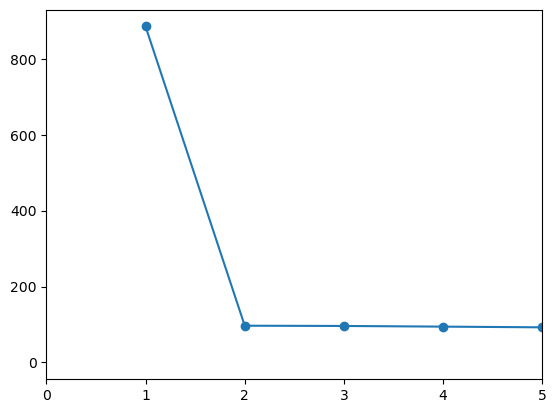

In [218]:
u, s, vt = np.linalg.svd(A)
plt.plot(np.arange(1, len(s) + 1), s, marker='o')
plt.xlim(0, 5)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

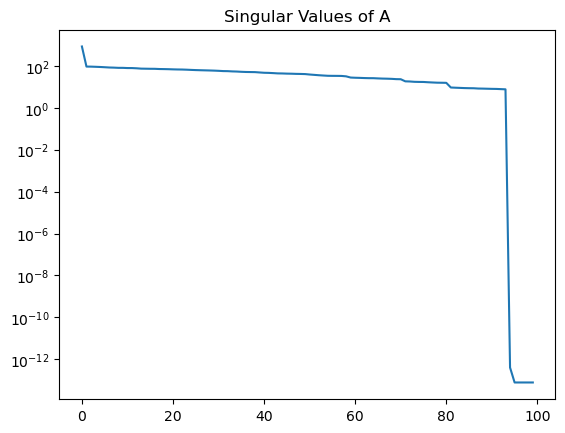

In [219]:
plt.semilogy(s)
plt.title("Singular Values of A")
plt.show

In [220]:
k = 1

In [221]:
def optimal_s_lambda(A, C, k):
    """
    Find optimal values of lambda and block size
    """
    m = np.shape(A)[0]
    u, s, vt = np.linalg.svd(A)
    tail = s[k:]
    k_bar_k = (np.linalg.norm(A, ord = "fro") / np.min(tail)) / np.sqrt(len(tail))   #normalized tail condition number
    
    optimal_s = np.ceil(C * k * np.log(m * k_bar_k)) # optimal block size
    optimal_lambda = (k / m) * np.mean(tail ** 2)
    return optimal_s, optimal_lambda

In [222]:
def update_rho_adaptive(residuals, i, p, r_hat_prev):
    """
    Adaptive rho update based on averaged residual norm squared ratios.
    """
    if len(residuals) < 2 * p:
        return 0.9, r_hat_prev  # default fallback

    eps_t = np.mean([r**2 for r in residuals[-p:]])
    eps_tp = np.mean([r**2 for r in residuals[-2*p:-p]])
    r_ip = eps_t / eps_tp

    a_i = (i + 1) ** np.log(i + 1)
    alpha = (a_i - 1) / a_i

    r_hat = alpha * r_hat_prev + (1 - alpha) * r_ip
    rho_new = 1 - r_hat ** (1 / p)
    rho_new = max(min(rho_new, 1), 0.0)  # clamp rho to [0, 1] to avoid negative rhos, causing divergence

    return rho_new, r_hat

In [223]:
def kaczmarz(A, b, lamb, rho, eta, n_steps, block_size, p, x_true = None):
    m, n = A.shape
    x = np.zeros((n,1))
    residuals = []
    residual_norms = []
    update_norms = []
    errors = []
    rhos = []
    
    mtm = 0
    r_hat = 1
    checkpoint_idx = 1

    b_norm = np.linalg.norm(b)
    
    for t in range(n_steps):
        tau = np.random.choice(m, block_size, replace=False)
        A_tau = A[tau, :]
        b_tau = b[tau]
    
        #regularized projection: 
        w = A_tau.T @ np.linalg.inv(A_tau @ A_tau.T + lamb * np.eye(block_size)) @ (A_tau @ x - b_tau)
        mtm_new = ((1 - rho)/(1 + rho))*(mtm - w)
        x_new = x - w + eta * mtm_new

        #storing residual, which should be getting smaller
        system = A @ x_new - b
        residuals.append(np.linalg.norm(system))
        residual_norms.append(np.linalg.norm(system) / b_norm)

        #storing update size
        update_norms.append(np.linalg.norm(x_new - x))

        #storing error
        if x_true is not None:
            errors.append(np.linalg.norm(x_new - x_true))

        if t % p == 0 and t >= 2 * p:
            rho, r_hat = update_rho_adaptive(residuals, checkpoint_idx, p, r_hat)
            checkpoint_idx += 1
            
        rhos.append(rho)    
        x = x_new
        mtm = mtm_new

    return x, residuals, residual_norms, update_norms, errors, rhos

In [224]:
def verify(A, b, l, r, e, bl_s, x_true):
     #Run Kaczmarz
    x_kacz, residuals, residual_norms, update_norms, errors, rhos = kaczmarz(A, b, lamb = l, rho = r, eta = e, n_steps = 10, block_size = bl_s, p = 10, x_true = x_true)

    #Plot metrics
    fig, axs = plt.subplots(3, 1, figsize=(10, 10))

    axs[0].plot(residuals)
    axs[0].set_title("1. Residual Norm ||Ax - b|| (inconsistent system)")
    axs[0].set_xlabel("Iteration")
    axs[0].set_ylabel("Residual")

    axs[1].plot(update_norms)
    axs[1].set_title("2. Update Norm ||x_{t+1} - x_t||")
    axs[1].set_xlabel("Iteration")
    axs[1].set_ylabel("Update Size")

    axs[2].plot(errors)
    axs[2].set_title("3. Error Norm ||x - x_true||")
    axs[2].set_xlabel("Iteration")
    axs[2].set_ylabel("Error")

    plt.tight_layout()
    plt.show()


In [225]:
#block size, lambda
s = optimal_s_lambda(A, 1, k)[0].astype(int)
lamb = optimal_s_lambda(A, 1, k)[1]
eta = s/(2*n)
s, eta

(42, 0.21)

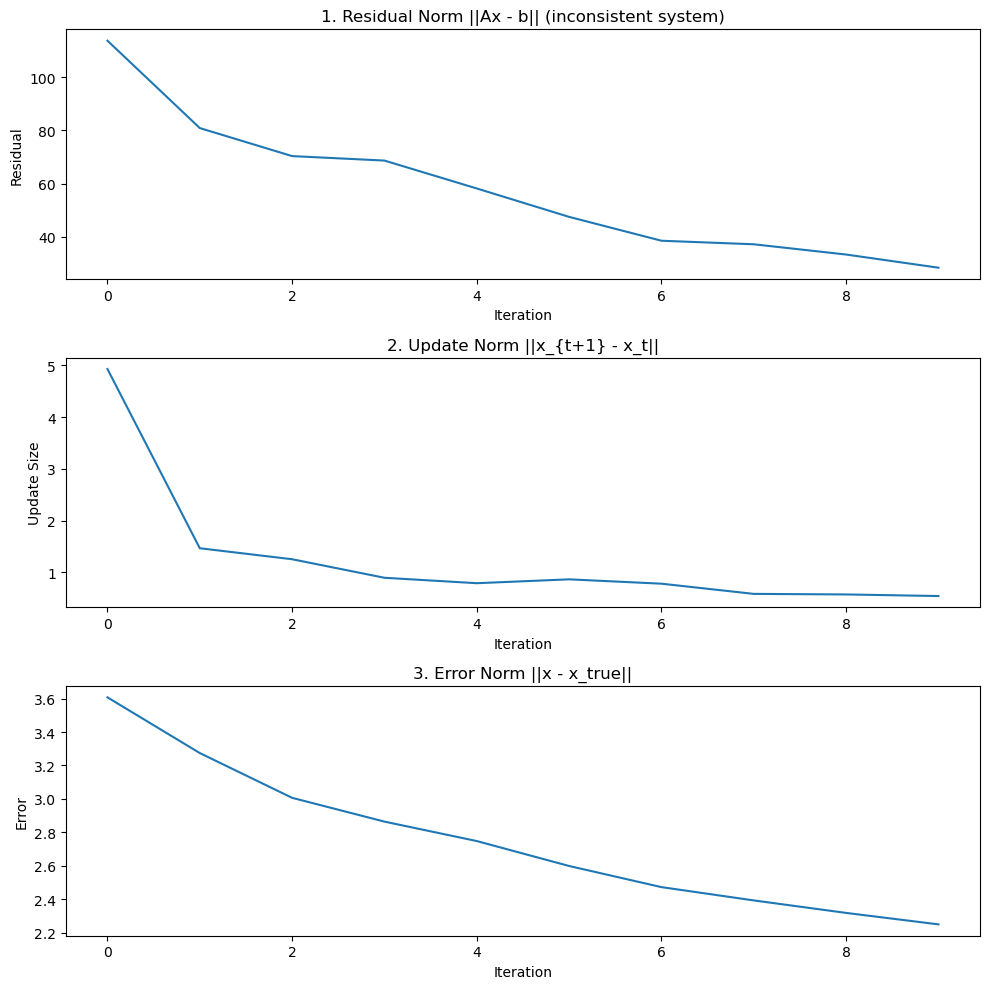

In [226]:
verify(A = A, b = b, l = lamb, r = 0.9, e = eta, bl_s = s, x_true = x_true)

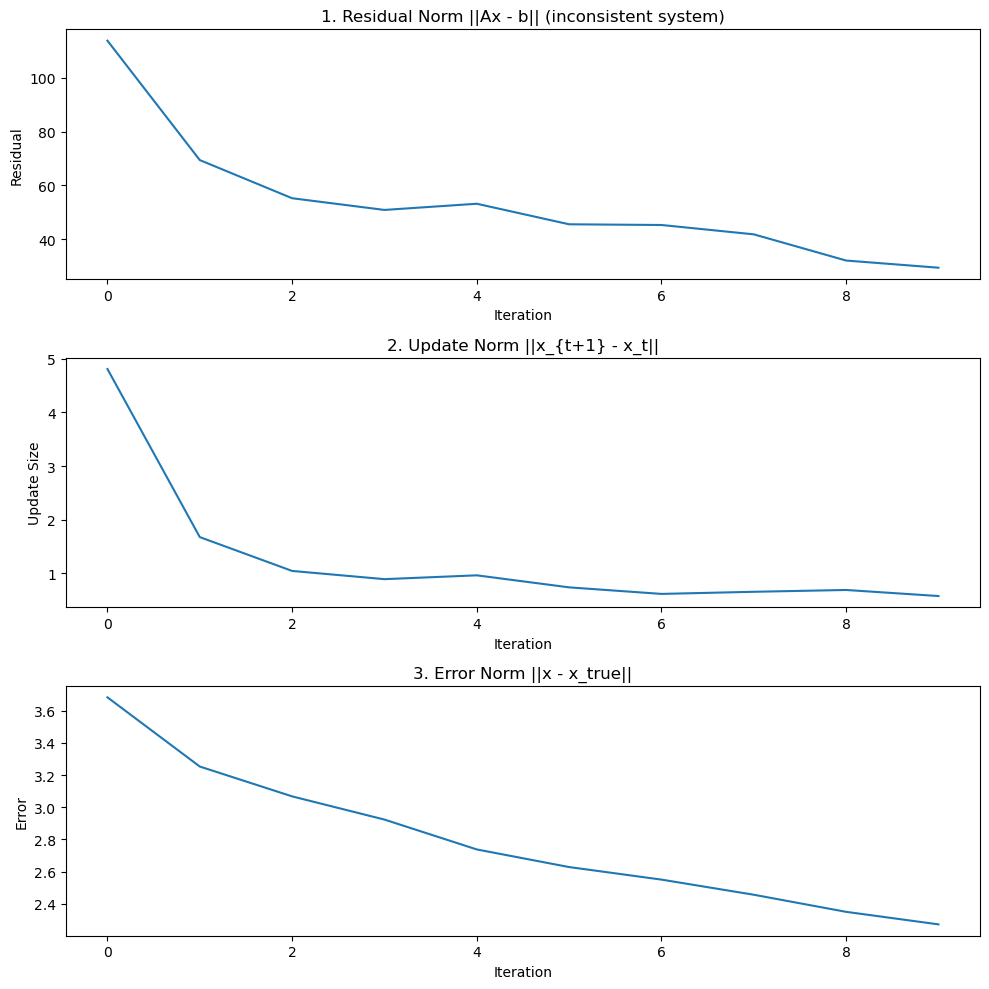

In [227]:
verify(A, b, l = lamb, r = 0, e = 0, bl_s = s, x_true = x_true)

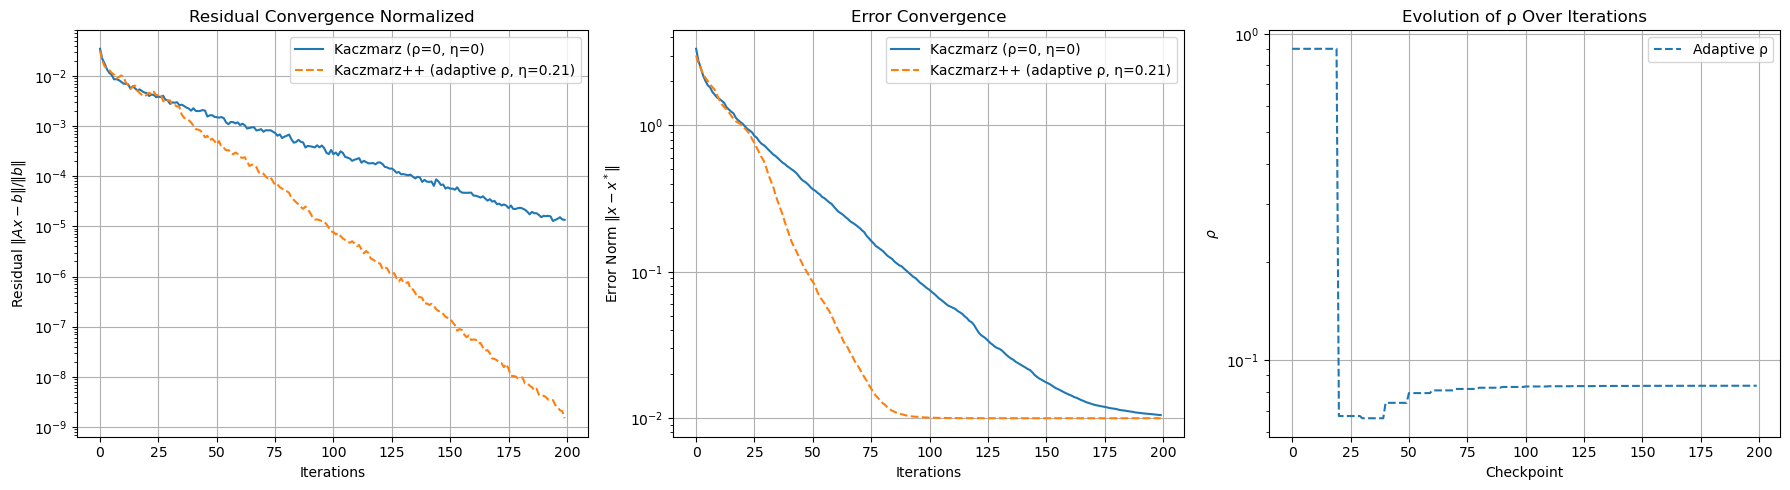

In [228]:
#no adaptive acceleration
x_kacz_reg, residuals_reg, residual_norms_reg, update_norms_reg, errors_reg, rhos_reg = kaczmarz(A, b, lamb = lamb, rho = 0, eta = 0, n_steps = 200, block_size = s, p = 10, x_true = x_star)
#adaptive acceleration
x_kacz_aa, residuals_reg_aa, residual_norms_aa, update_norms_reg_aa, errors_reg_aa, rhos_aa = kaczmarz(A, b, lamb = lamb, rho = 0.9, eta = eta, n_steps = 200, block_size = s, p = 10, x_true = x_star)


fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Residual
axs[0].plot(residual_norms_reg, label="Kaczmarz (ρ=0, η=0)")
axs[0].plot(residual_norms_aa, label=f"Kaczmarz++ (adaptive ρ, η={eta})", linestyle='--')
axs[0].set_yscale("log")
axs[0].set_title("Residual Convergence Normalized")
axs[0].set_xlabel("Iterations")
axs[0].set_ylabel(r"Residual $\|Ax - b\| / \|b\|$")
axs[0].legend()
axs[0].grid(True)

# Error
axs[1].plot(errors_reg, label="Kaczmarz (ρ=0, η=0)")
axs[1].plot(errors_reg_aa, label=f"Kaczmarz++ (adaptive ρ, η={eta})", linestyle='--')
axs[1].set_yscale("log")
axs[1].set_title("Error Convergence")
axs[1].set_xlabel("Iterations")
axs[1].set_ylabel(r"Error Norm $\|x - x^*\|$")
axs[1].legend()
axs[1].grid(True)

# Adaptive ρ
axs[2].plot(rhos_aa, label="Adaptive ρ", linestyle='--')
axs[2].set_yscale("log")
axs[2].set_title("Evolution of ρ Over Iterations")
axs[2].set_xlabel("Checkpoint")
axs[2].set_ylabel(r"$\rho$")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


# #plot residual norms 
# plt.subplot(2,2,1)
# plt.yscale("log")
# plt.plot(residual_norms_reg, label="Kaczmarz (ρ=0, η=0)")
# #plt.plot(res_fixed, label="Kaczmarz++ (ρ=0.9, η=0.5)")
# plt.plot(residual_norms_aa, label=f"Kaczmarz++ (adaptive ρ, η={eta})")
# plt.xlabel("Iterations")
# plt.ylabel(r"Residual $\|Ax - b\| / \|b\|$")
# plt.title("Residual Convergence Normalized")
# plt.grid(True)
# plt.legend()

# #plot error norms
# plt.subplot(2, 2, 2)
# plt.plot(errors_reg, label='Kaczmarz (ρ=0, η=0)', color = "blue")
# plt.plot(errors_reg_aa, label=f'Kaczmarz++ (adaptive ρ, η={eta})', color = "red", linestyle='--')
# plt.yscale("log")
# plt.xlabel("Iteration")
# plt.ylabel("Error Norm ||x - x_star||")
# plt.title("Error Convergence")
# plt.grid(True)
# plt.legend()

# #plot adaptive rho
# plt.subplot(2, 2, 3)
# plt.plot(rhos_aa, label="Adaptive ρ", color = "red", linestyle = "--")
# plt.yscale("log")
# plt.title("Evolution of ρ Over Iterations")
# plt.xlabel("Iteration")
# plt.ylabel("ρ")
# plt.grid(True)
# plt.legend()

# plt.tight_layout()
# plt.show()

In [229]:
p_values = [1, 5, 10, 20, 50, 100]
results = {}

for p in p_values:
    x_out, residuals, residual_norms, update_norms, errors, rhos = kaczmarz(
        A, b, lamb=lamb, rho=0.9, eta=eta,
        n_steps=200, block_size=s, x_true=x_true, p=p
    )
    results[p] = {
        'residuals': residuals,
        'errors': errors,
        'rhos': rhos
    }

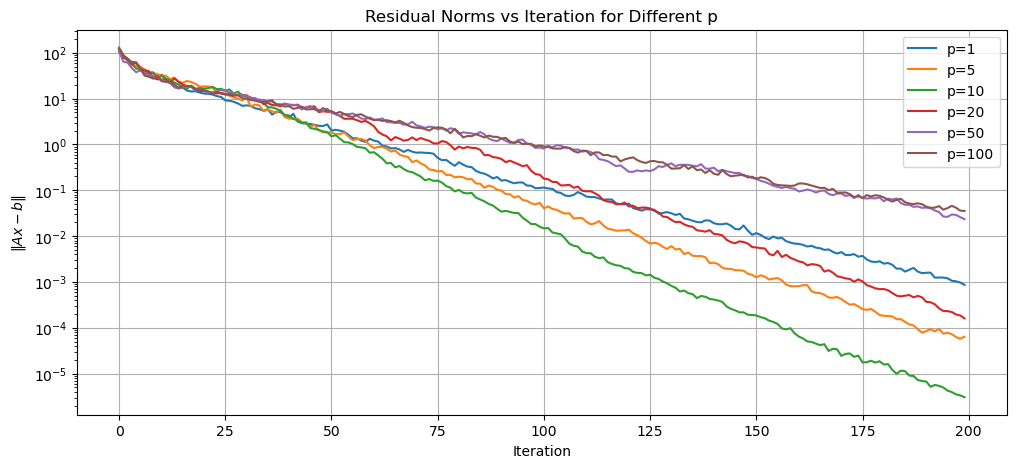

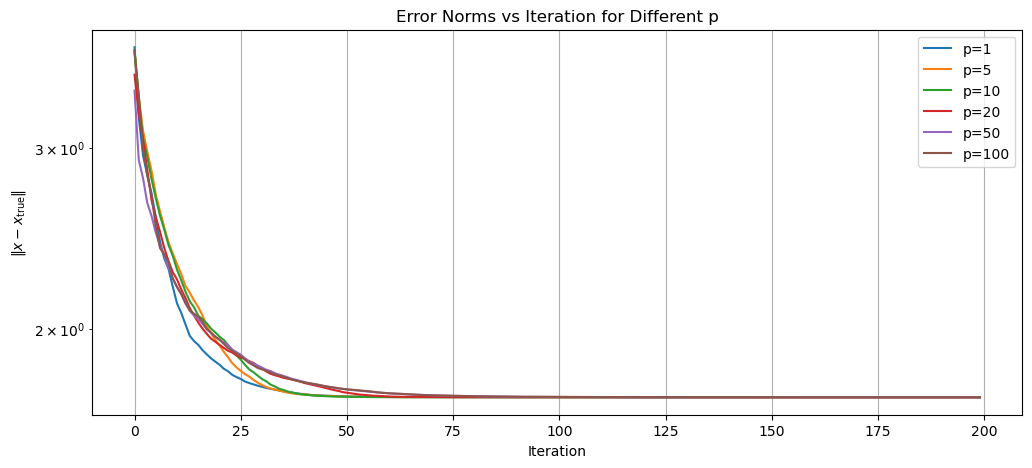

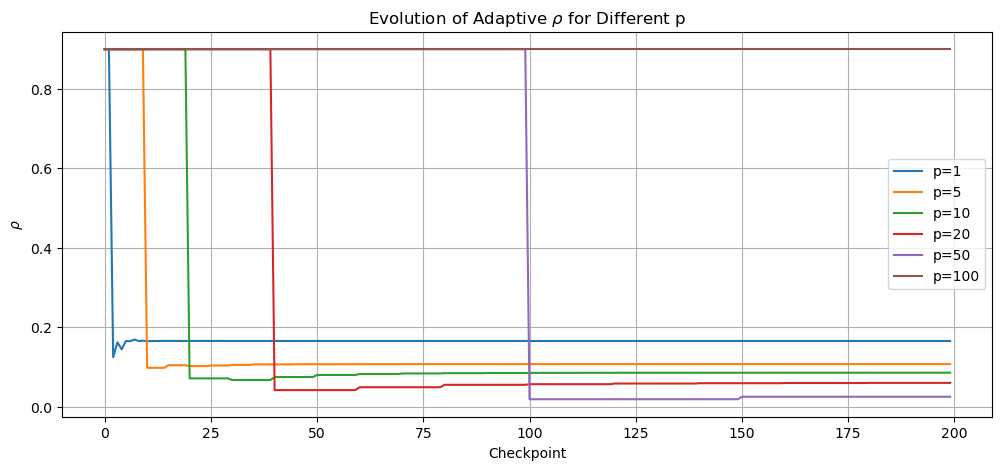

In [230]:
# Residuals plot
plt.figure(figsize=(12, 5))
for p in p_values:
    plt.plot(results[p]['residuals'], label=f"p={p}")
plt.yscale("log")
plt.title("Residual Norms vs Iteration for Different p")
plt.xlabel("Iteration")
plt.ylabel(r"$\|Ax - b\|$")
plt.legend()
plt.grid(True)
plt.show()

# Error plot
plt.figure(figsize=(12, 5))
for p in p_values:
    if results[p]['errors']:  # check if not None
        plt.plot(results[p]['errors'], label=f"p={p}")
plt.yscale("log")
plt.title("Error Norms vs Iteration for Different p")
plt.xlabel("Iteration")
plt.ylabel(r"$\|x - x_{\mathrm{true}}\|$")
plt.legend()
plt.grid(True)
plt.show()

# Rho plot
plt.figure(figsize=(12, 5))
for p in p_values:
    plt.plot(results[p]['rhos'], label=f"p={p}")
plt.title("Evolution of Adaptive $\\rho$ for Different p")
plt.xlabel("Checkpoint")
plt.ylabel(r"$\rho$")
plt.legend()
plt.grid(True)
plt.show()

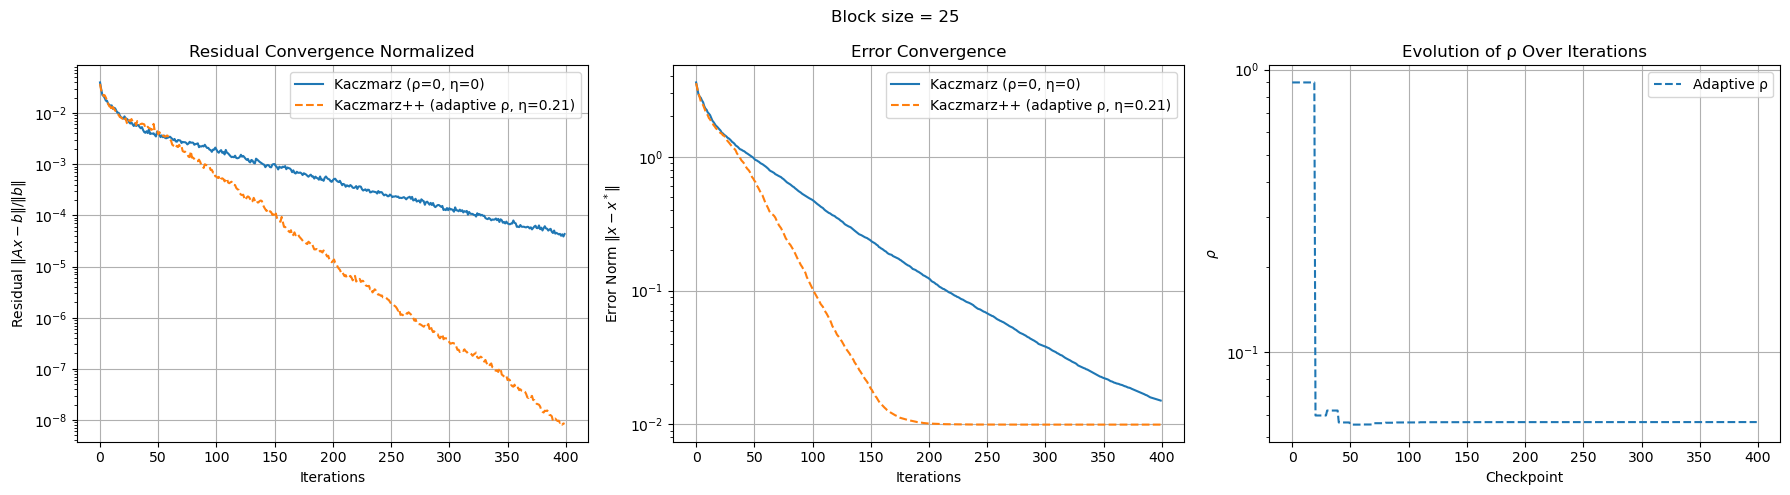

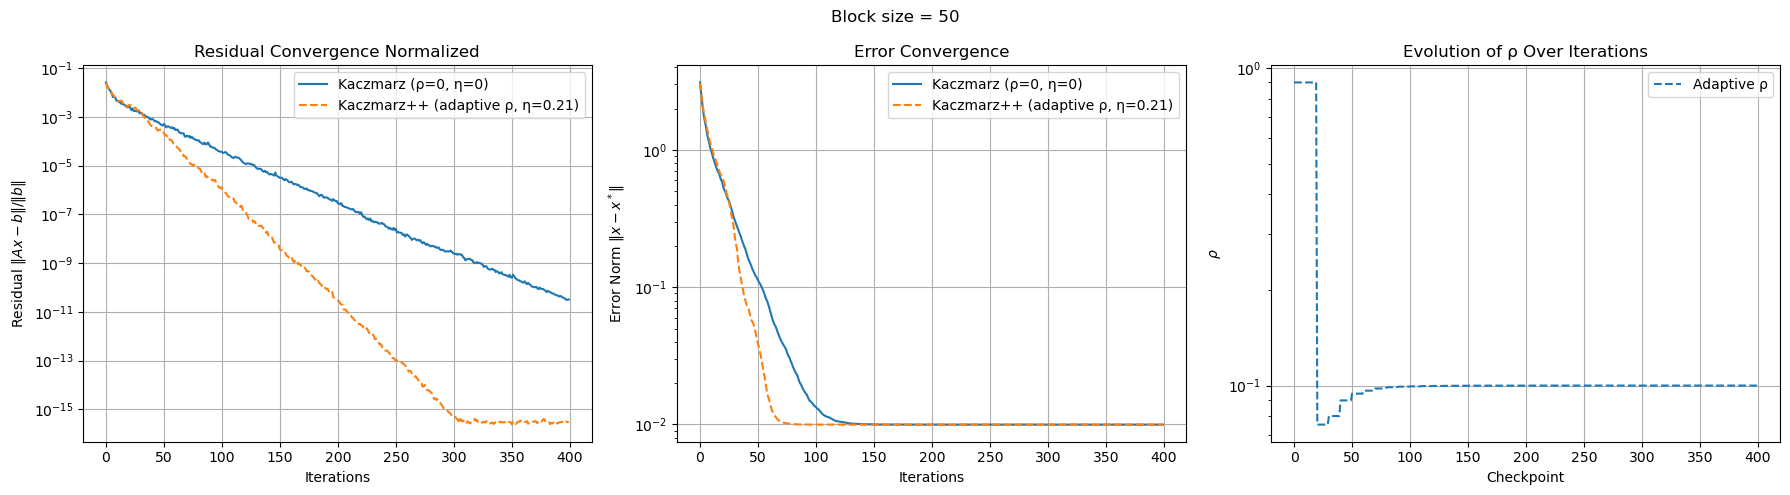

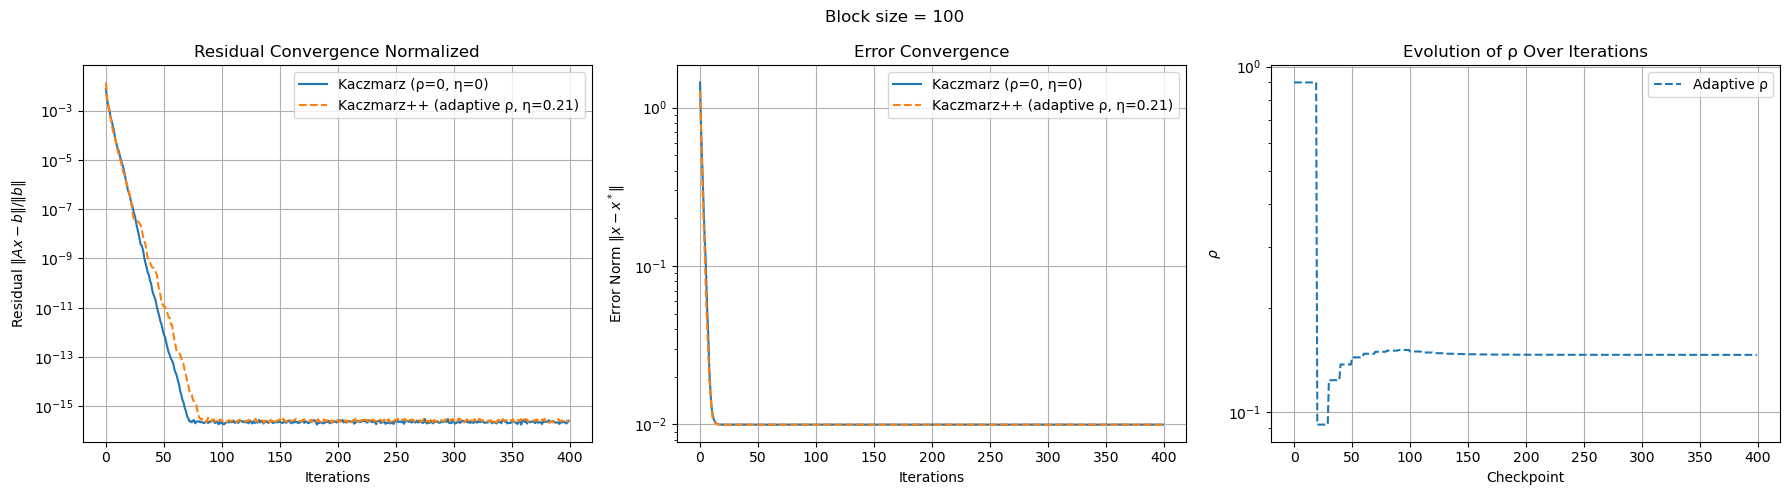

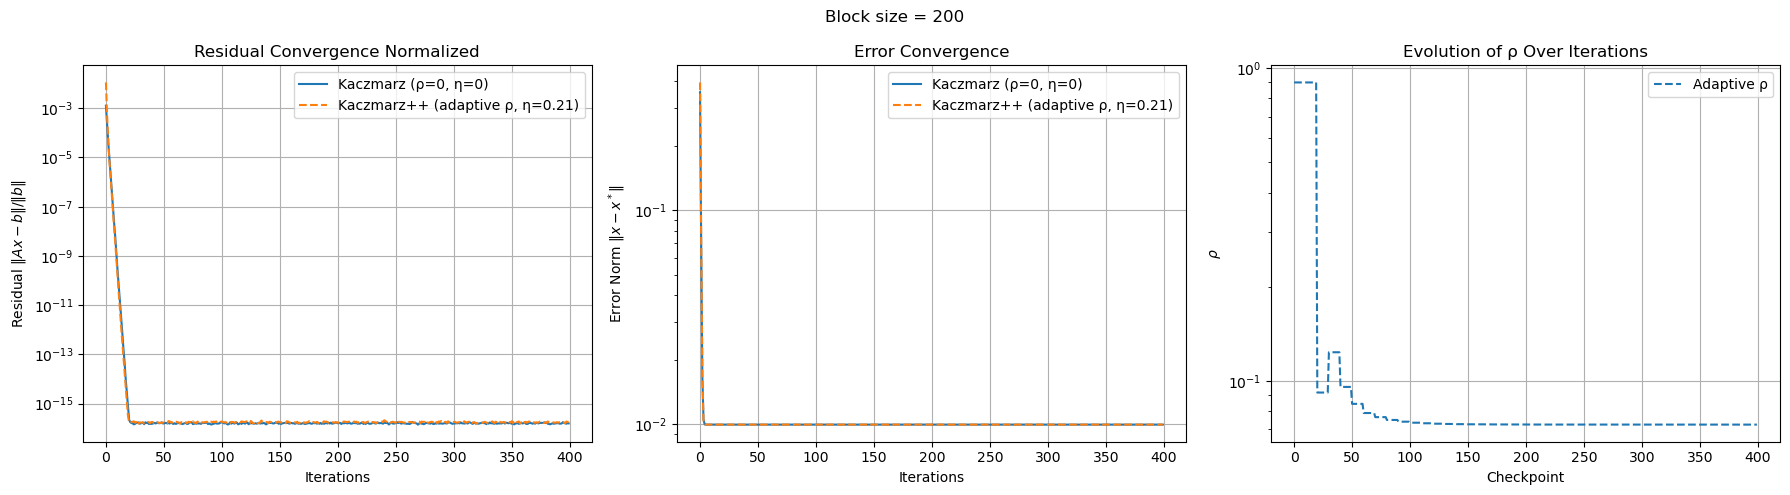

In [231]:
potential_block_sizes = np.array([25, 50, 100, 200])

for size in potential_block_sizes:
    #no adaptive acceleration
    x_kacz_reg, residuals_reg, residual_norms_reg, update_norms_reg, errors_reg, rhos_reg = kaczmarz(A, b, lamb = lamb, rho = 0, eta = 0, n_steps = 400, block_size = size, p = 10, x_true = x_star)
    #adaptive acceleration
    x_kacz_aa, residuals_reg_aa, residual_norms_aa, update_norms_reg_aa, errors_reg_aa, rhos_aa = kaczmarz(A, b, lamb = lamb, rho = 0.9, eta = eta, n_steps = 400, block_size = size, p = 10, x_true = x_star)


    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"Block size = {size}")

    # Residual
    axs[0].plot(residual_norms_reg, label="Kaczmarz (ρ=0, η=0)")
    axs[0].plot(residual_norms_aa, label=f"Kaczmarz++ (adaptive ρ, η={eta})", linestyle='--')
    axs[0].set_yscale("log")
    axs[0].set_title("Residual Convergence Normalized")
    axs[0].set_xlabel("Iterations")
    axs[0].set_ylabel(r"Residual $\|Ax - b\| / \|b\|$")
    axs[0].legend()
    axs[0].grid(True)
    
    # Error
    axs[1].plot(errors_reg, label="Kaczmarz (ρ=0, η=0)")
    axs[1].plot(errors_reg_aa, label=f"Kaczmarz++ (adaptive ρ, η={eta})", linestyle='--')
    axs[1].set_yscale("log")
    axs[1].set_title("Error Convergence")
    axs[1].set_xlabel("Iterations")
    axs[1].set_ylabel(r"Error Norm $\|x - x^*\|$")
    axs[1].legend()
    axs[1].grid(True)
    
    # Adaptive ρ
    axs[2].plot(rhos_aa, label="Adaptive ρ", linestyle='--')
    axs[2].set_yscale("log")
    axs[2].set_title("Evolution of ρ Over Iterations")
    axs[2].set_xlabel("Checkpoint")
    axs[2].set_ylabel(r"$\rho$")
    axs[2].legend()
    axs[2].grid(True)
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_127/2765511535.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_star = np.linalg.lstsq(A,b)[0] #even though b = Ax, block Kaczmarz projects onto minimum norm solution of Ax = b, i.e. x_star.


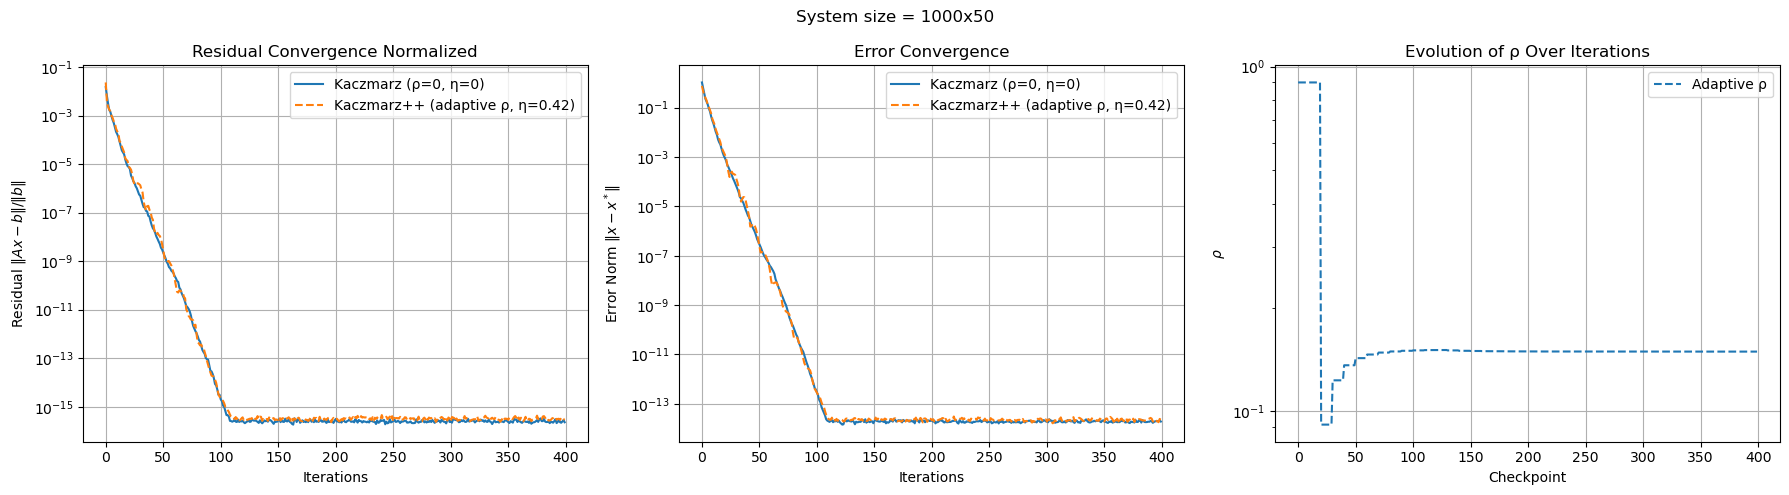

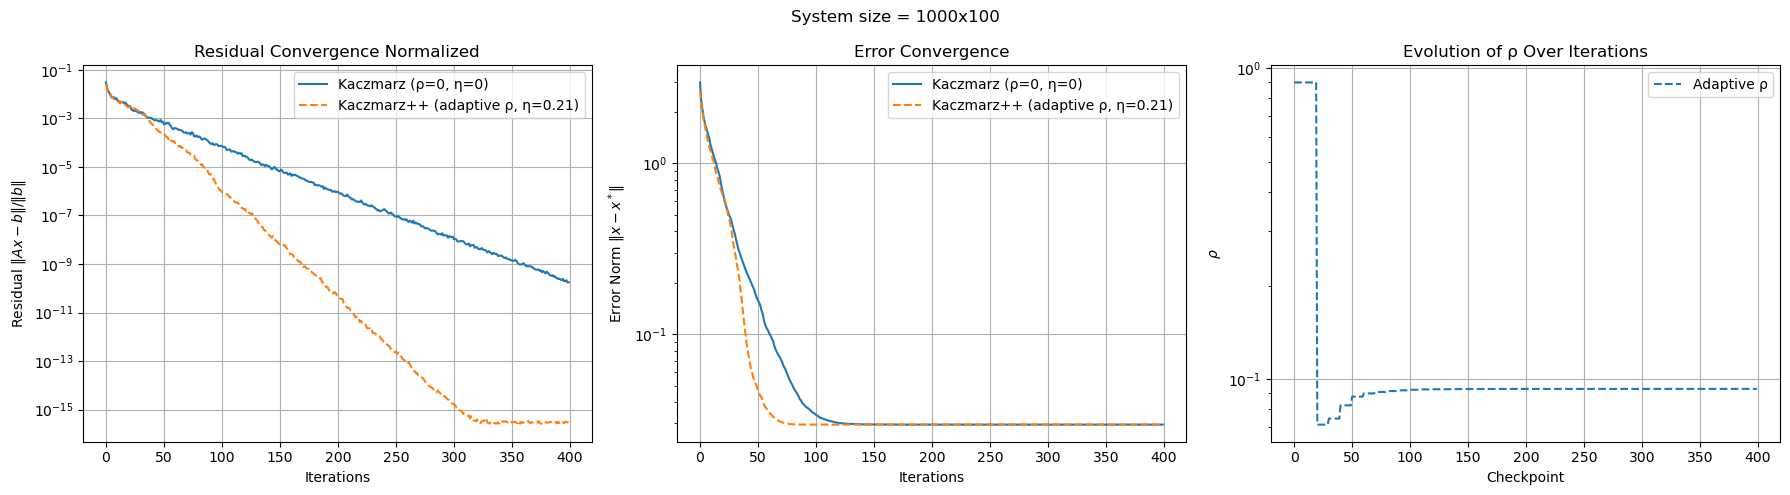

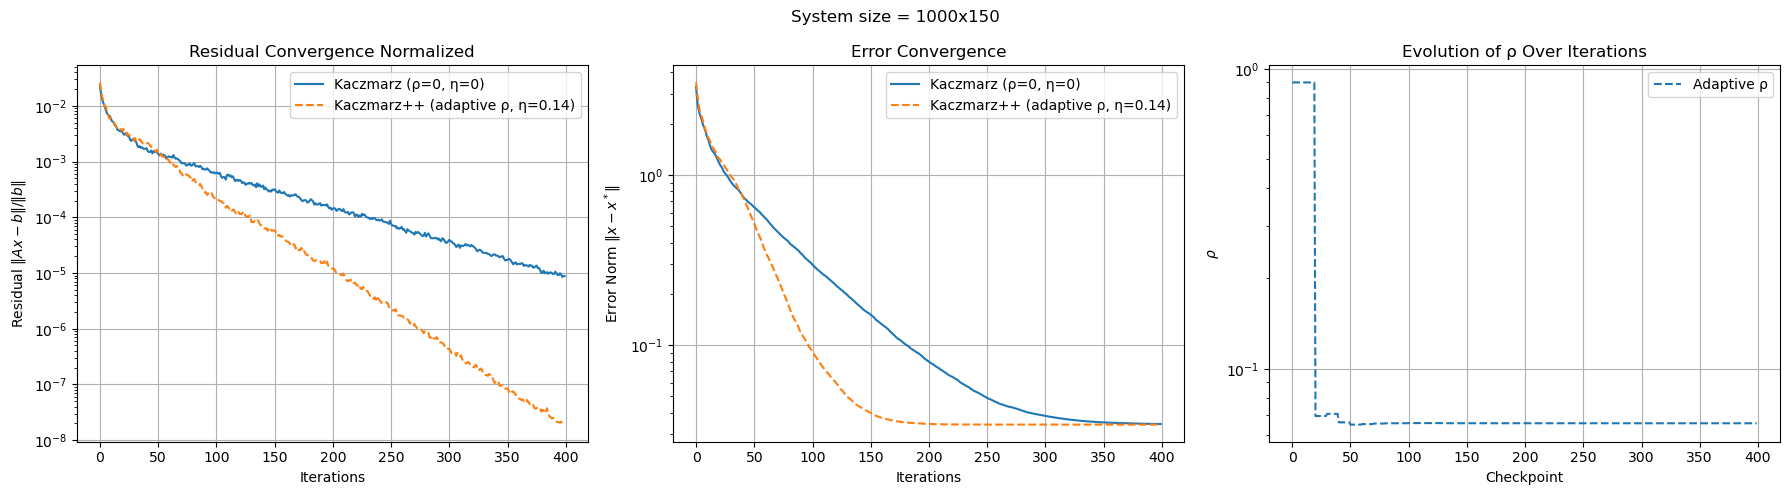

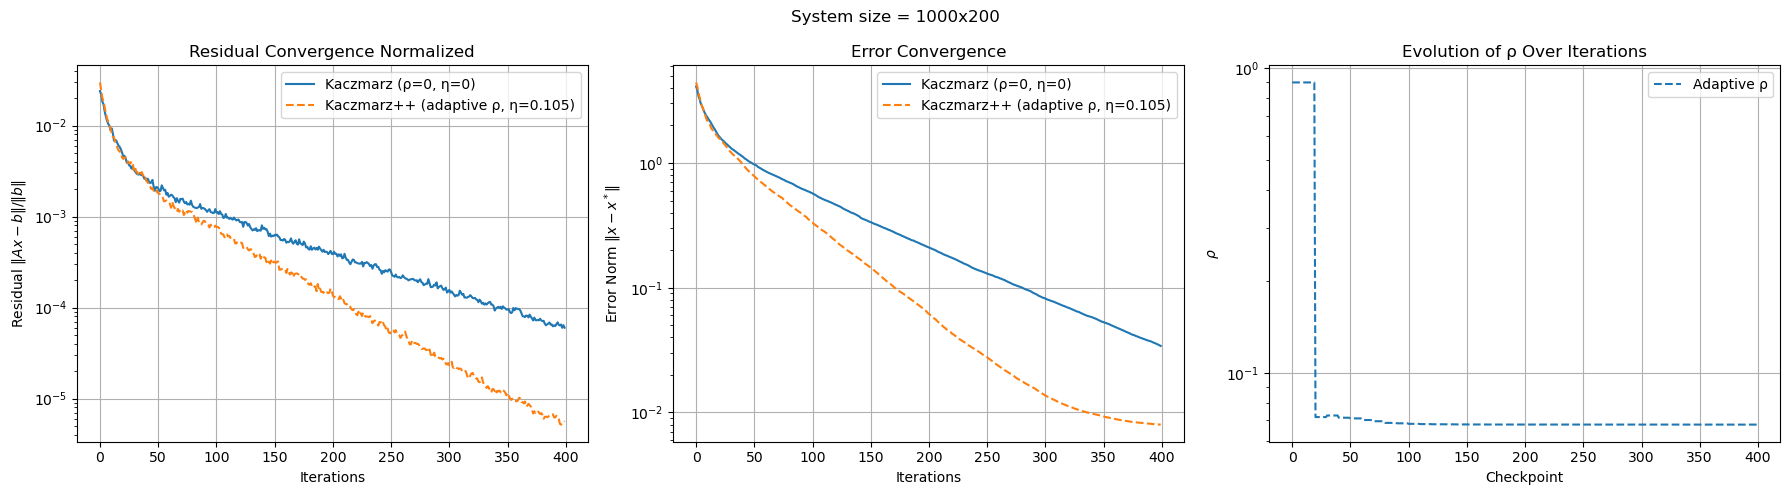

In [232]:
potential_n_values = np.array([50, 100, 150, 200])
for pot_n in potential_n_values:
    A, b, x_true, x_star = generate_rand_system(1000, pot_n)
    eta = s/(2*pot_n)
    #no adaptive acceleration
    x_kacz_reg, residuals_reg, residual_norms_reg, update_norms_reg, errors_reg, rhos_reg = kaczmarz(A, b, lamb = lamb, rho = 0, eta = 0, n_steps = 400, block_size = 50, p = 10, x_true = x_star)
    #adaptive acceleration
    x_kacz_aa, residuals_reg_aa, residual_norms_aa, update_norms_reg_aa, errors_reg_aa, rhos_aa = kaczmarz(A, b, lamb = lamb, rho = 0.9, eta = eta, n_steps = 400, block_size = 50, p = 10, x_true = x_star)

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"System size = 1000x{pot_n}")

    # Residual
    axs[0].plot(residual_norms_reg, label="Kaczmarz (ρ=0, η=0)")
    axs[0].plot(residual_norms_aa, label=f"Kaczmarz++ (adaptive ρ, η={eta})", linestyle='--')
    axs[0].set_yscale("log")
    axs[0].set_title("Residual Convergence Normalized")
    axs[0].set_xlabel("Iterations")
    axs[0].set_ylabel(r"Residual $\|Ax - b\| / \|b\|$")
    axs[0].legend()
    axs[0].grid(True)
    
    # Error
    axs[1].plot(errors_reg, label="Kaczmarz (ρ=0, η=0)")
    axs[1].plot(errors_reg_aa, label=f"Kaczmarz++ (adaptive ρ, η={eta})", linestyle='--')
    axs[1].set_yscale("log")
    axs[1].set_title("Error Convergence")
    axs[1].set_xlabel("Iterations")
    axs[1].set_ylabel(r"Error Norm $\|x - x^*\|$")
    axs[1].legend()
    axs[1].grid(True)
    
    # Adaptive ρ
    axs[2].plot(rhos_aa, label="Adaptive ρ", linestyle='--')
    axs[2].set_yscale("log")
    axs[2].set_title("Evolution of ρ Over Iterations")
    axs[2].set_xlabel("Checkpoint")
    axs[2].set_ylabel(r"$\rho$")
    axs[2].legend()
    axs[2].grid(True)
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_127/2765511535.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_star = np.linalg.lstsq(A,b)[0] #even though b = Ax, block Kaczmarz projects onto minimum norm solution of Ax = b, i.e. x_star.


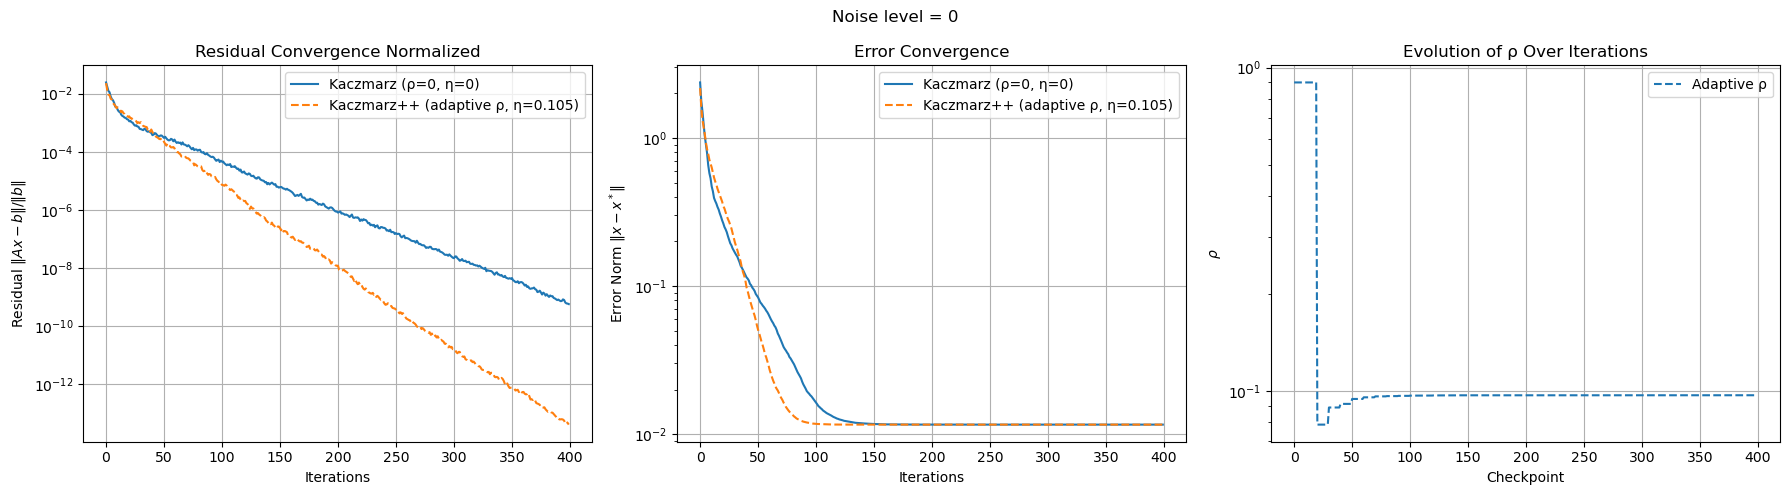

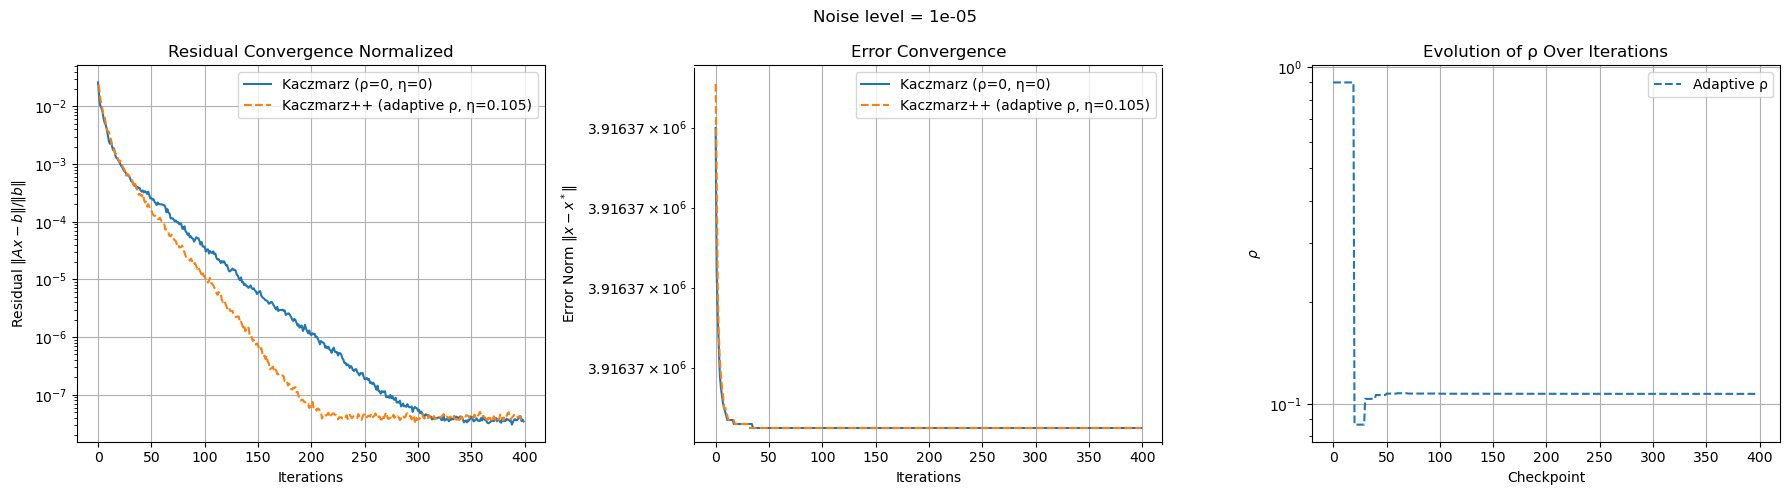

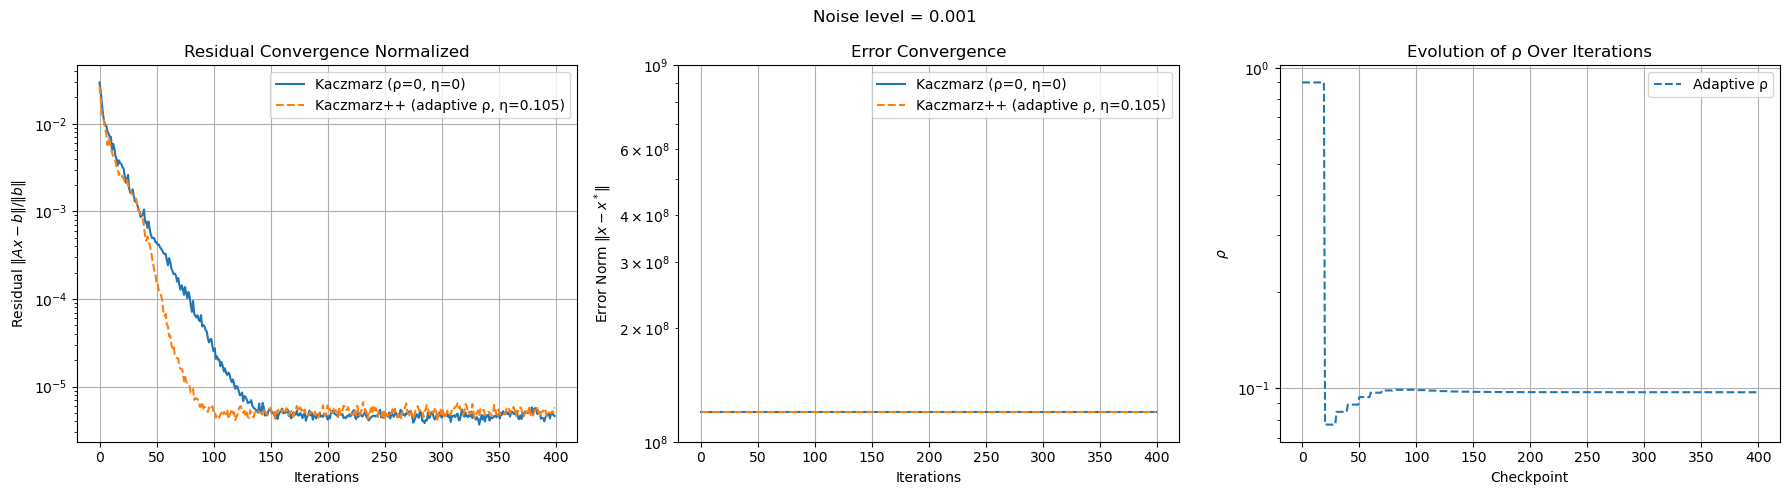

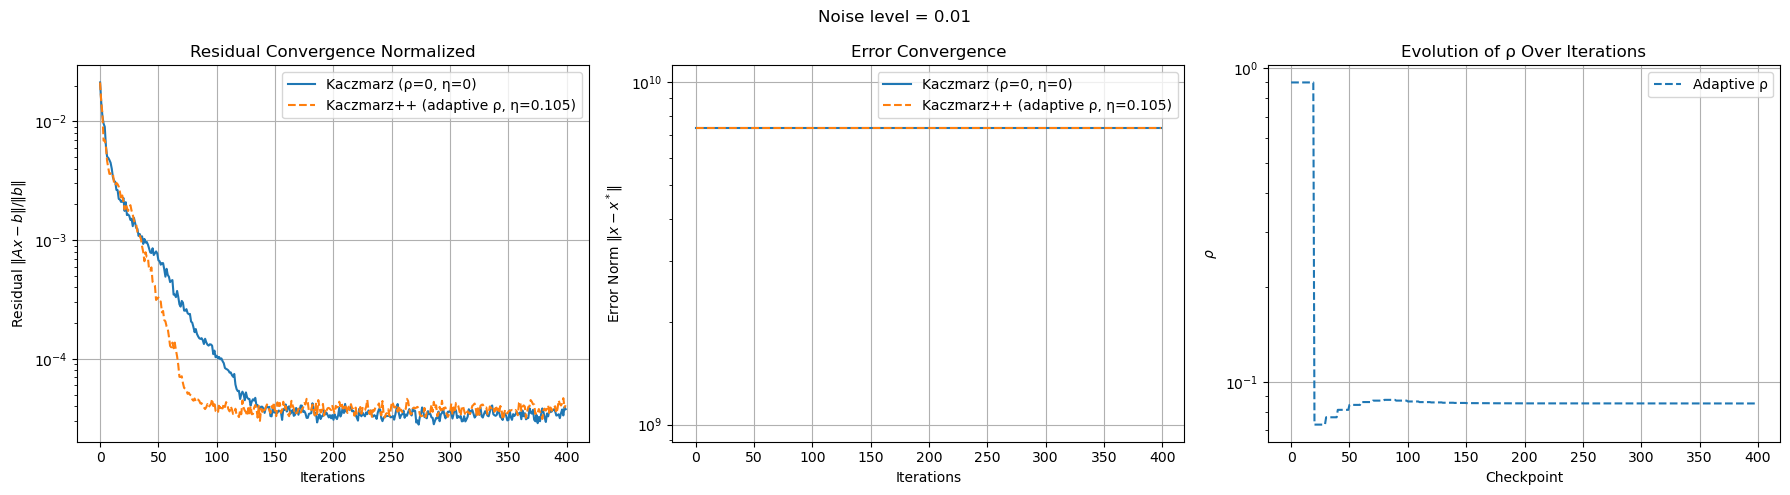

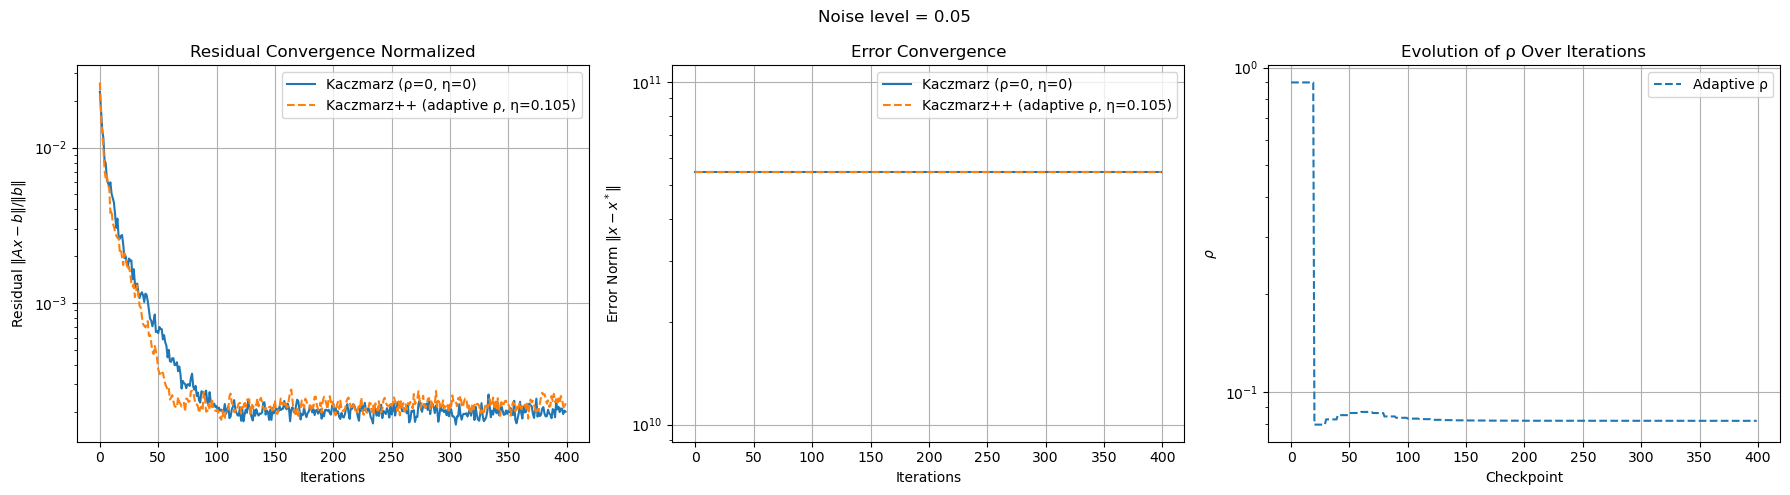

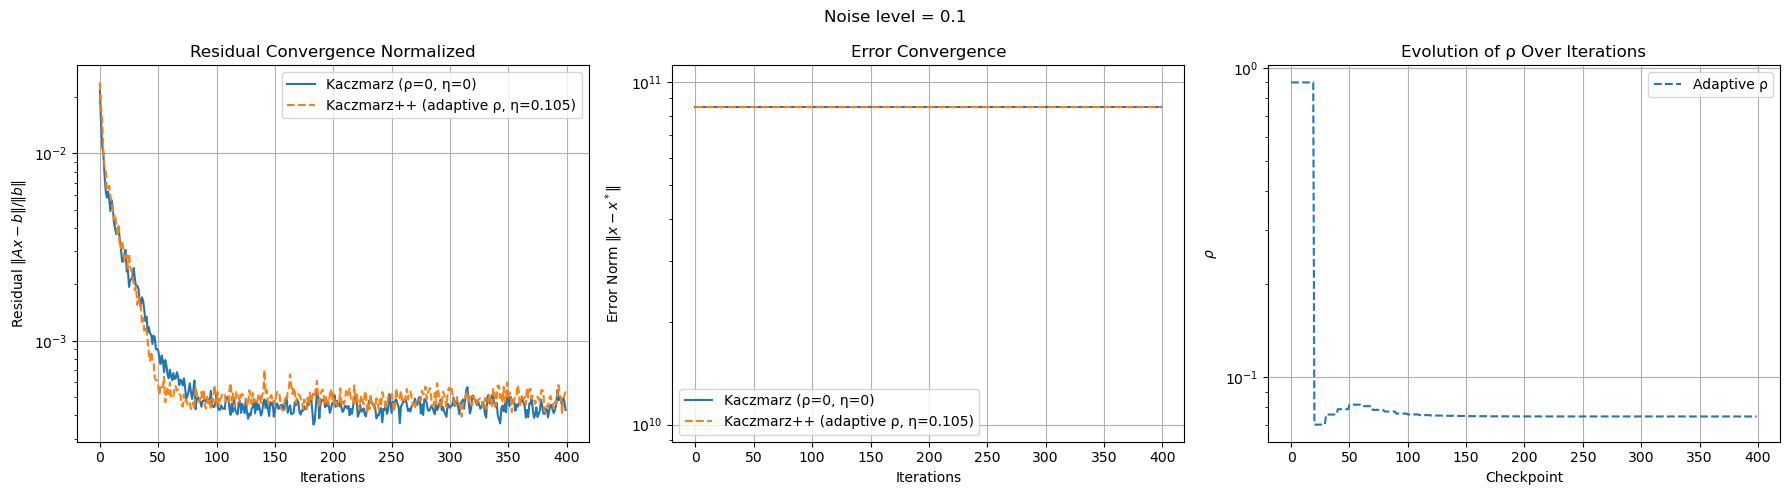

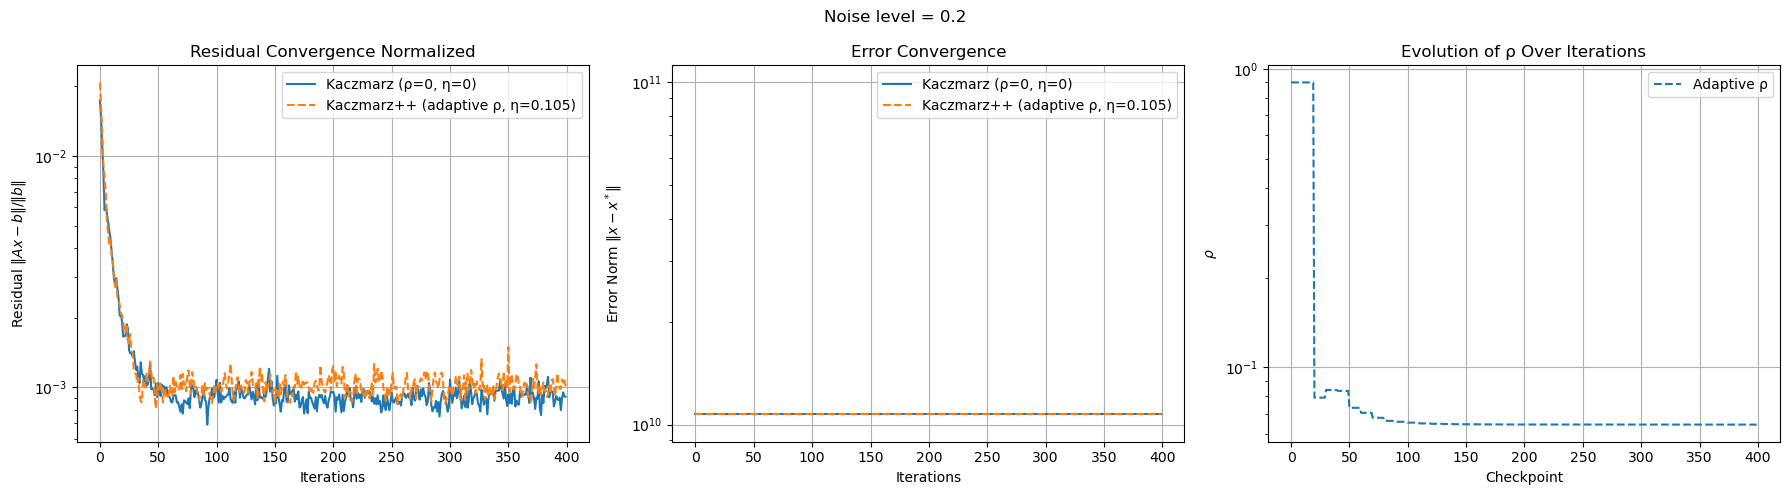

In [234]:
noise_levels = [0, 1e-5, 1e-3, 1e-2, 0.05, 0.1, 0.2]

for noise in noise_levels:
    A, b, x_true, x_star = generate_rand_system(m,n, noise_std = noise)
    
    #no adaptive acceleration
    x_kacz_reg, residuals_reg, residual_norms_reg, update_norms_reg, errors_reg, rhos_reg = kaczmarz(A, b, lamb = lamb, rho = 0, eta = 0, n_steps = 400, block_size = 50, p = 10, x_true = x_star)
    #adaptive acceleration
    x_kacz_aa, residuals_reg_aa, residual_norms_aa, update_norms_reg_aa, errors_reg_aa, rhos_aa = kaczmarz(A, b, lamb = lamb, rho = 0.9, eta = eta, n_steps = 400, block_size = 50, p = 10, x_true = x_star)

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"Noise level = {noise}")

    # Residual
    axs[0].plot(residual_norms_reg, label="Kaczmarz (ρ=0, η=0)")
    axs[0].plot(residual_norms_aa, label=f"Kaczmarz++ (adaptive ρ, η={eta})", linestyle='--')
    axs[0].set_yscale("log")
    axs[0].set_title("Residual Convergence Normalized")
    axs[0].set_xlabel("Iterations")
    axs[0].set_ylabel(r"Residual $\|Ax - b\| / \|b\|$")
    axs[0].legend()
    axs[0].grid(True)
    
    # Error
    axs[1].plot(errors_reg, label="Kaczmarz (ρ=0, η=0)")
    axs[1].plot(errors_reg_aa, label=f"Kaczmarz++ (adaptive ρ, η={eta})", linestyle='--')
    axs[1].set_yscale("log")
    axs[1].set_title("Error Convergence")
    axs[1].set_xlabel("Iterations")
    axs[1].set_ylabel(r"Error Norm $\|x - x^*\|$")
    axs[1].legend()
    axs[1].grid(True)
    
    # Adaptive ρ
    axs[2].plot(rhos_aa, label="Adaptive ρ", linestyle='--')
    axs[2].set_yscale("log")
    axs[2].set_title("Evolution of ρ Over Iterations")
    axs[2].set_xlabel("Checkpoint")
    axs[2].set_ylabel(r"$\rho$")
    axs[2].legend()
    axs[2].grid(True)
    
    plt.tight_layout()
    plt.show()
    